# Project 2 - Supervised Learning

### Let's first check the data in the **train.csv**

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import time

train_data = pd.read_csv('train.csv')

# Remove oversampling
claimed = train_data[train_data['is_claim'] == 1]
not_claimed = train_data[train_data['is_claim'] == 0]
sample_size = min(len(claimed), len(not_claimed))
train_data = pd.concat([claimed.sample(n=sample_size), not_claimed.sample(n=sample_size)])

print(train_data.head())

      policy_id  policy_tenure  age_of_car  age_of_policyholder area_cluster   
19324   ID19325       0.971883        0.15             0.298077           C8  \
50620   ID50621       1.061809        0.05             0.403846           C8   
55647   ID55648       0.959466        0.00             0.375000           C6   
33402   ID33403       0.744018        0.02             0.644231           C3   
11121   ID11122       1.209354        0.09             0.442308          C13   

       population_density  make segment model fuel_type  ... is_brake_assist   
19324                8794     3      C2    M4    Diesel  ...             Yes  \
50620                8794     3      C2    M4    Diesel  ...             Yes   
55647               13051     1       A    M1       CNG  ...              No   
33402                4076     1      B2    M6    Petrol  ...             Yes   
11121                5410     1      B2    M6    Petrol  ...             Yes   

      is_power_door_locks is_central_l

We had to have the same number of claims and not claims to avoid **oversampling**

### Let's check if there are columns with missing values
### And change the non-numeric columns to numeric

In [184]:
cols_with_na = train_data.columns[train_data.isna().any()].tolist()
print('Columns with missing values:', cols_with_na)

# train_data['policy_id'] = train_data['policy_id'].apply(lambda x: x.replace('ID', ''))
train_data.drop('policy_id', axis=1, inplace=True)
train_data['area_cluster'] = train_data['area_cluster'].apply(lambda x: x.replace('C', ''))
train_data = pd.get_dummies(train_data,
                            columns=['segment', 'fuel_type', 'engine_type', 'rear_brakes_type', 'steering_type'])
train_data['model'] = train_data['model'].apply(lambda x: x.replace('M', ''))
train_data = train_data.replace({"Yes": True, "No": False})
encoder = LabelEncoder()
train_data['transmission_type'] = encoder.fit_transform(train_data['transmission_type'])

train_data['max_torque'] = train_data['max_torque'].apply(
    lambda s: float(s.split('Nm@')[0]) * float(s.split('Nm@')[1].replace('rpm', '')))
train_data['max_power'] = train_data['max_power'].apply(
    lambda s: float(s.split('bhp@')[0]) * float(s.split('bhp@')[1].replace('rpm', '')))


Columns with missing values: []


As we can see, there are no missing values in our data set

### Let's now get some more general information of our features

In [185]:
print(train_data.describe())

       policy_tenure   age_of_car  age_of_policyholder  population_density   
count    7496.000000  7496.000000          7496.000000         7496.000000  \
mean        0.671524     0.066597             0.474240        18407.071638   
std         0.405483     0.054822             0.124733        17329.501408   
min         0.002782     0.000000             0.288462          290.000000   
25%         0.288224     0.020000             0.375000         6112.000000   
50%         0.693659     0.060000             0.461538         8794.000000   
75%         1.063722     0.110000             0.548077        27003.000000   
max         1.375988     0.390000             0.951923        73430.000000   

              make     max_torque      max_power      airbags  displacement   
count  7496.000000    7496.000000    7496.000000  7496.000000   7496.000000  \
mean      1.757604  443350.800427  401984.315902     3.129803   1163.330043   
std       1.138012  180977.697492  116323.745512     1.82718

In [ ]:
% matplotlib inline

sb.pairplot(train_data)

After some investigating, there are no major outliers that require work.
There are some variables that seem to have no correlation with the `is_claim` feature

### Now let's check what features have no correlation with the test feature

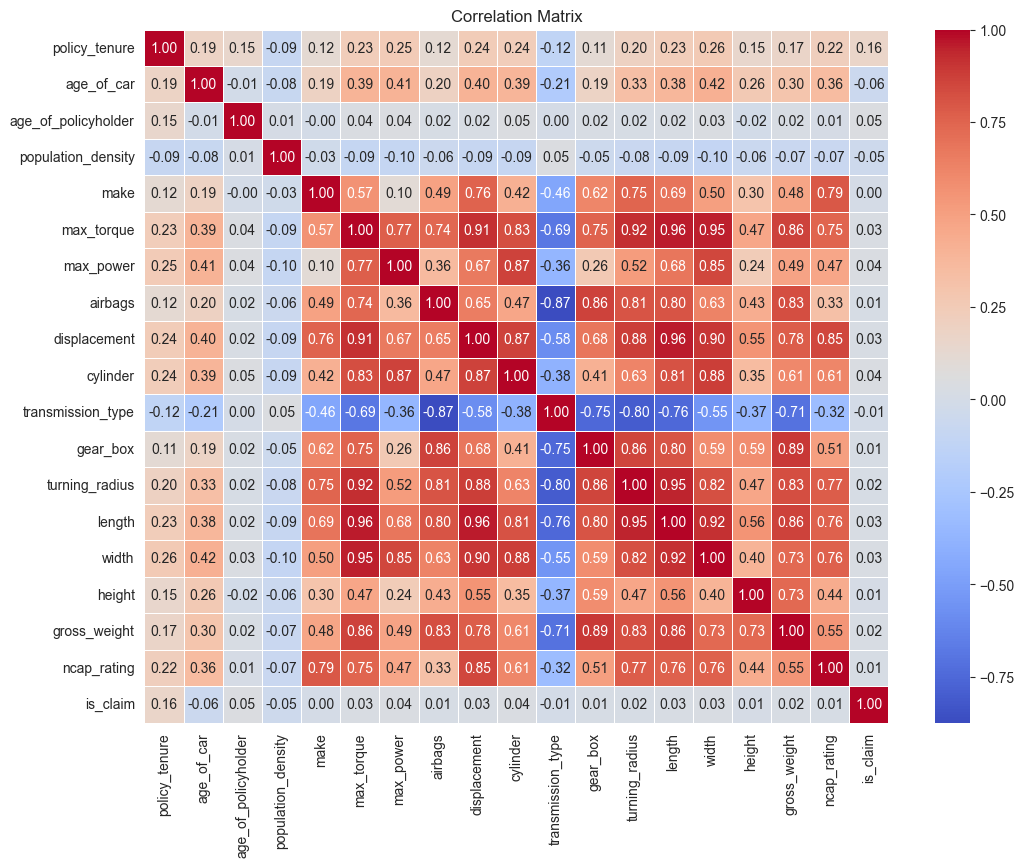

In [186]:

numeric_columns = train_data.select_dtypes(include='number')
train_data_numeric = train_data[numeric_columns.columns]



correlation_matrix = train_data_numeric.corr()

# Creating the subsets without the highly correlated features
corr_cols08 = set()
corr_cols09 = set()
corr_cols07 = set()
nocorr = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.columns[i] != correlation_matrix.columns[j] and abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[j]
            corr_cols08.add(colname)

        if correlation_matrix.columns[i] != correlation_matrix.columns[j] and abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[j]
            corr_cols09.add(colname)

        if correlation_matrix.columns[i] != correlation_matrix.columns[j] and abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[j]
            corr_cols07.add(colname)
    if correlation_matrix.columns[i] != "is_claim":
        j = (len(correlation_matrix.columns) - 1)
        if abs((correlation_matrix.iloc[i, j])) < 0.01:
            colname = correlation_matrix.columns[i]
            nocorr.add(colname)

train_data_08 = train_data_numeric.drop(columns=corr_cols08)
train_data_09 = train_data_numeric.drop(columns=corr_cols09)
train_data_07 = train_data_numeric.drop(columns=corr_cols07)
train_data_nocorr = train_data_numeric.drop(columns=nocorr)

train_data.to_csv('fixed_train_data.csv', index=False)
train_data_08.to_csv('fixed_train_data_08.csv', index=False)
train_data_09.to_csv('fixed_train_data_09.csv', index=False)
train_data_07.to_csv('fixed_train_data_07.csv', index=False)
train_data_nocorr.to_csv('fixed_train_data_nocorr.csv', index=False)

plt.figure(figsize=(12, 9))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

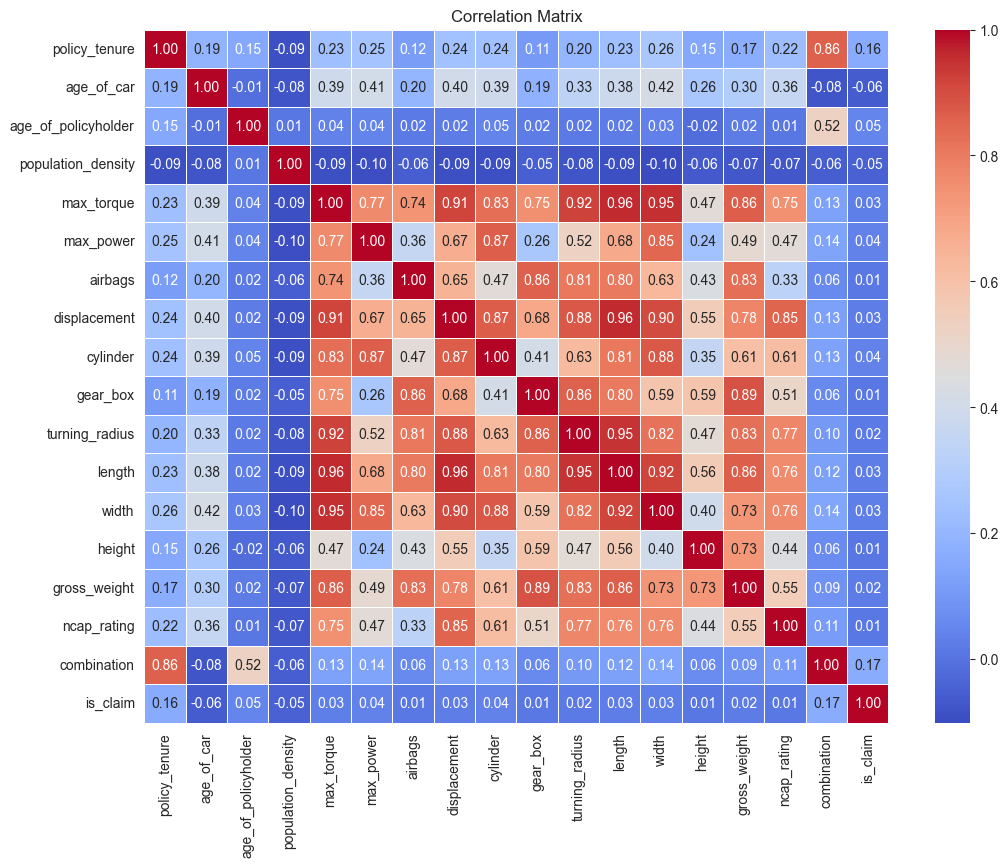

In [188]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

train_data_nocorr.insert(len(train_data_nocorr.columns) - 1, 'combination', train_data_nocorr['policy_tenure'] * train_data_nocorr['age_of_policyholder'] - train_data_nocorr['age_of_car'])

correlation_matrix = train_data_nocorr.corr()

plt.figure(figsize=(12, 9))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

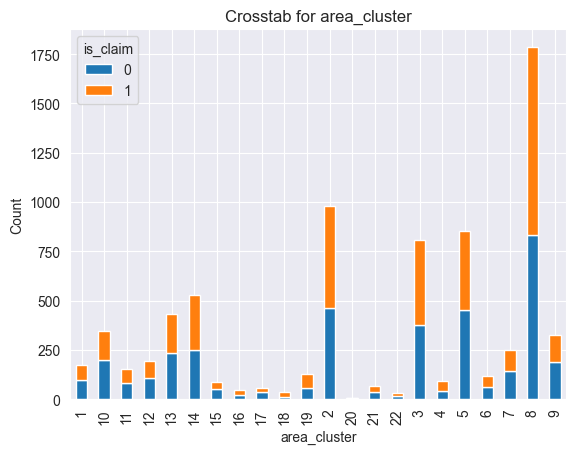

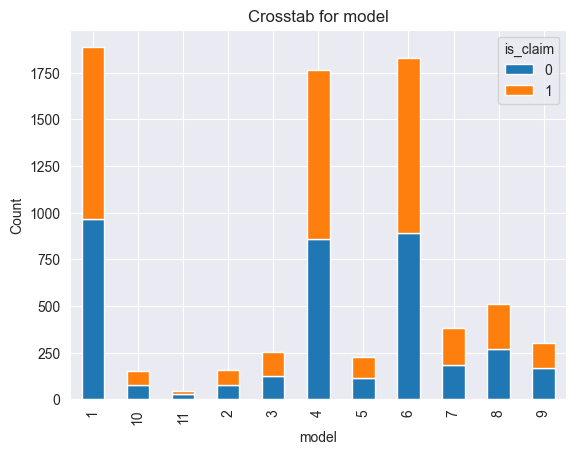

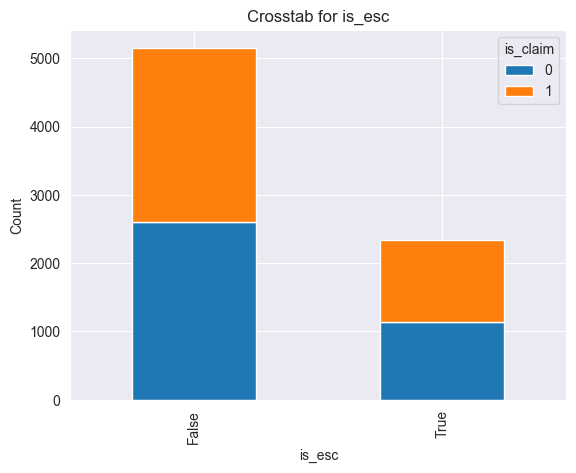

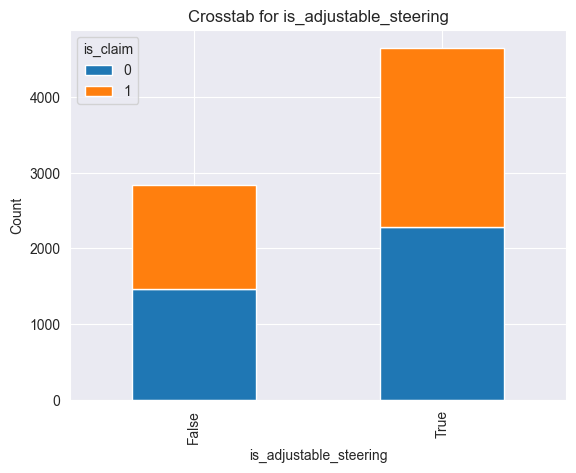

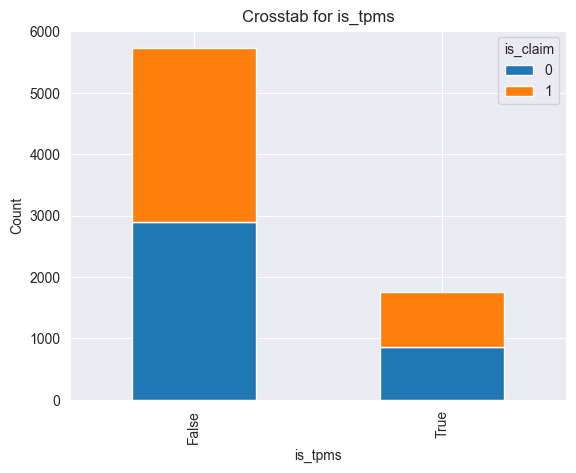

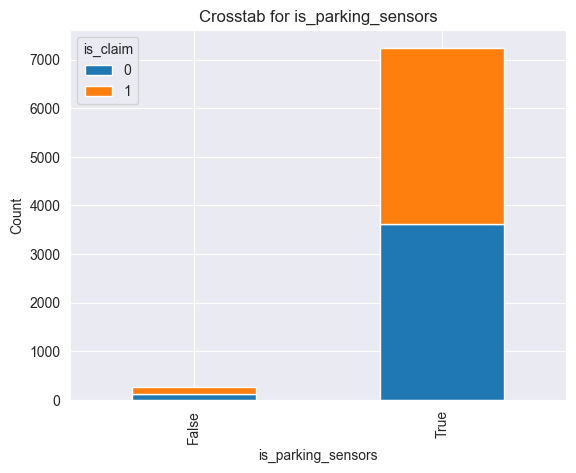

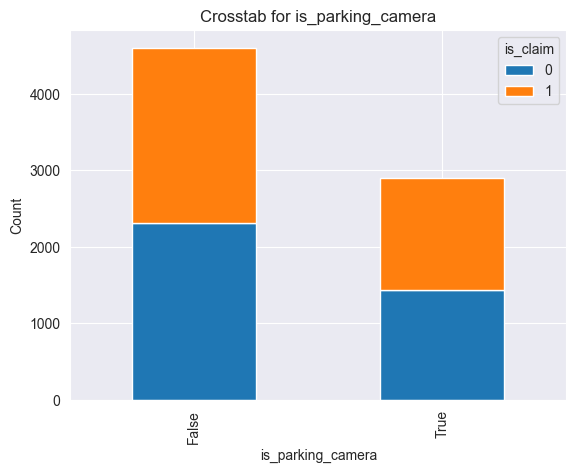

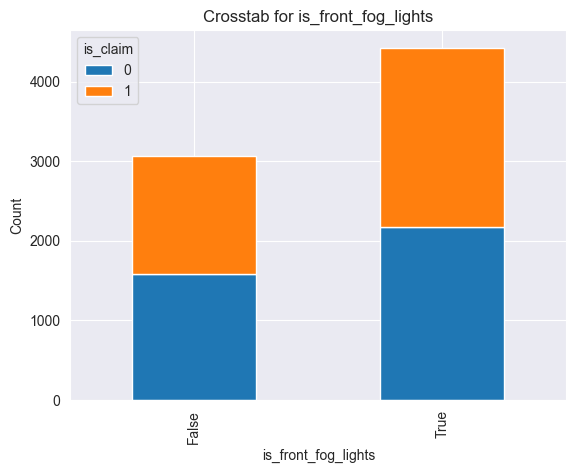

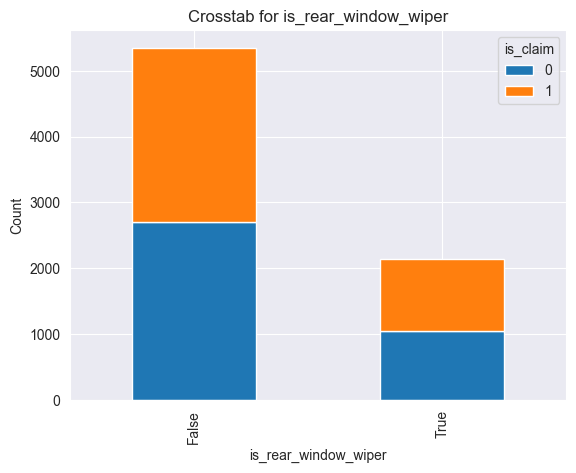

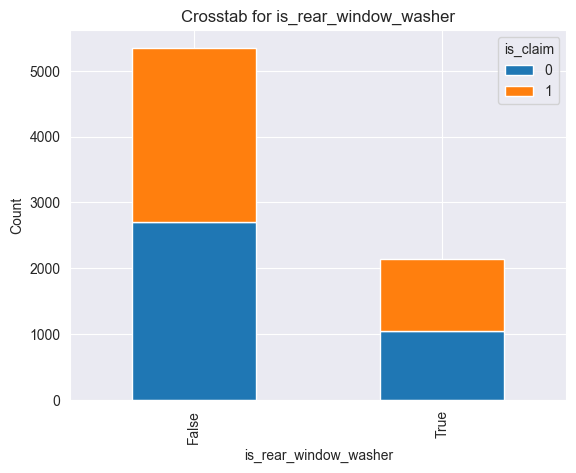

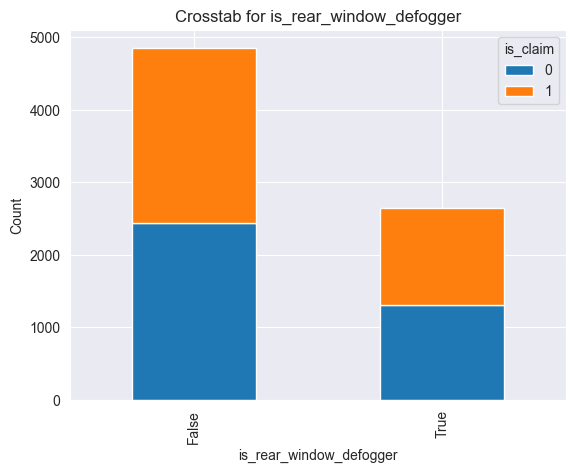

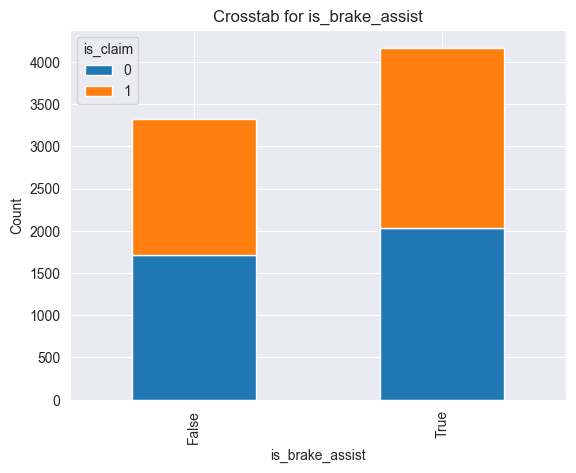

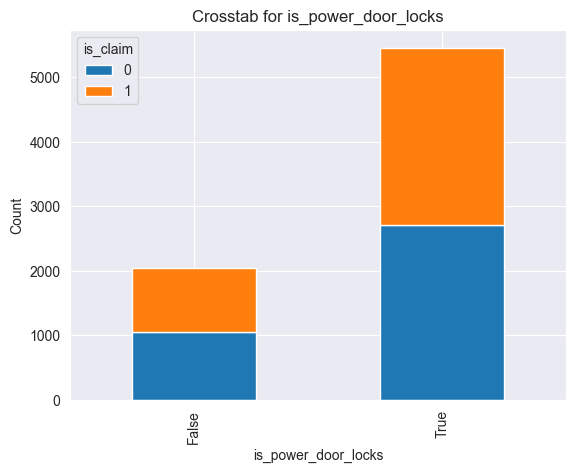

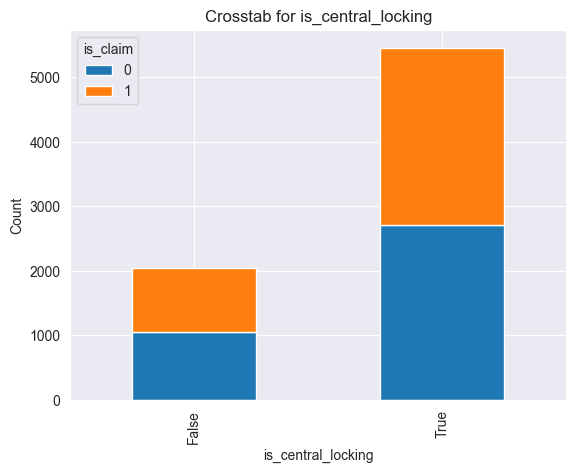

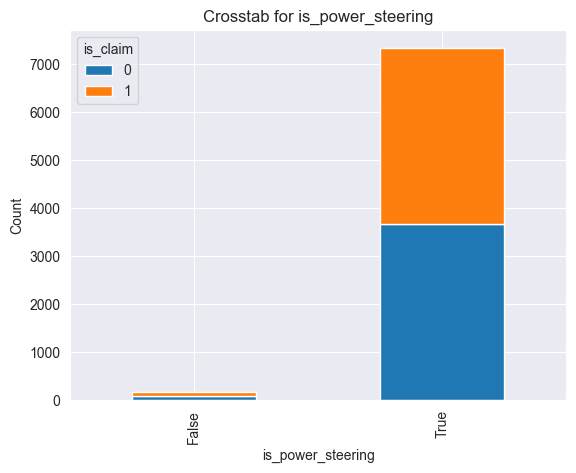

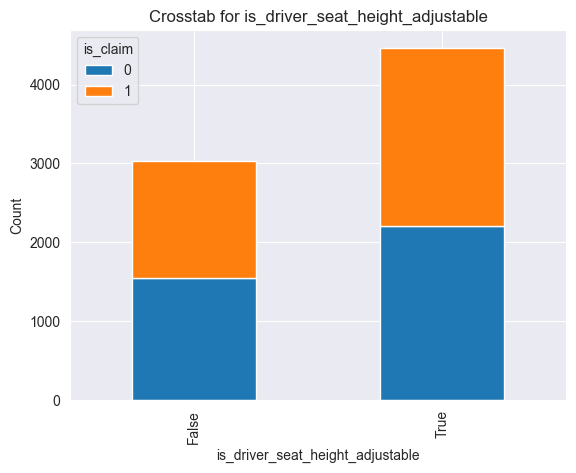

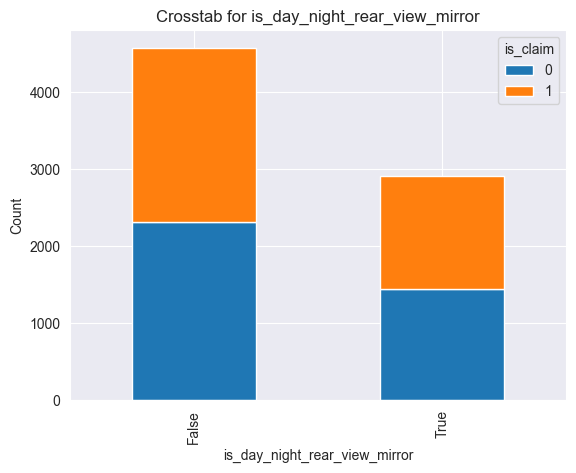

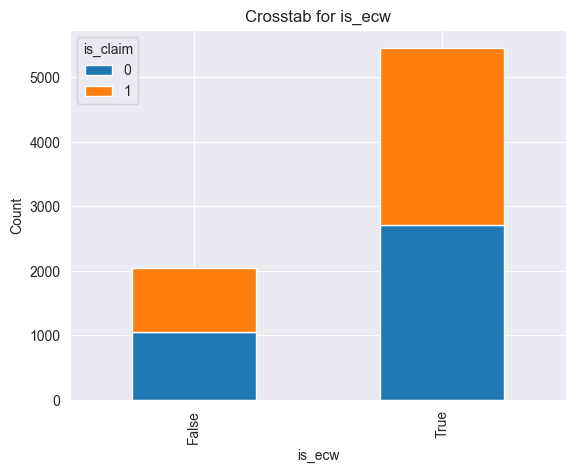

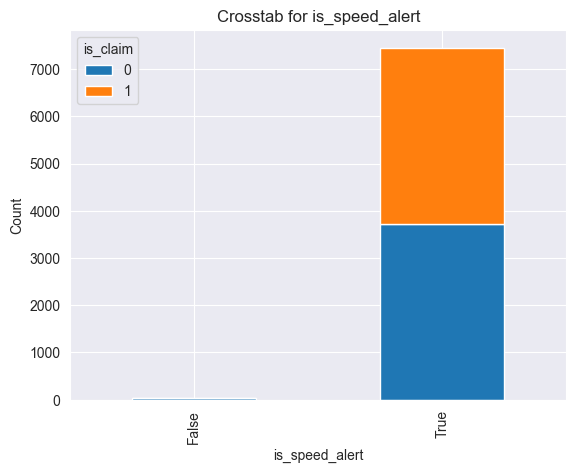

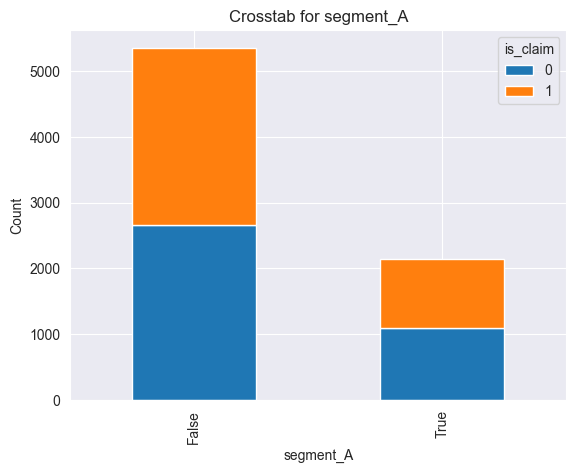

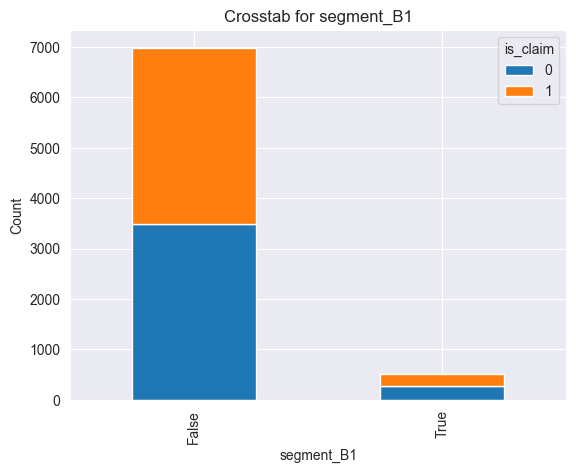

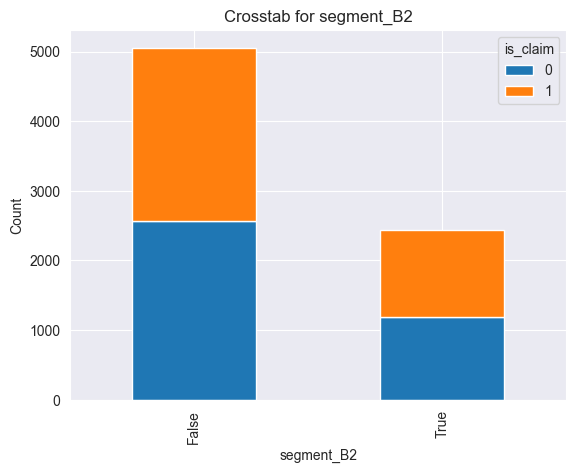

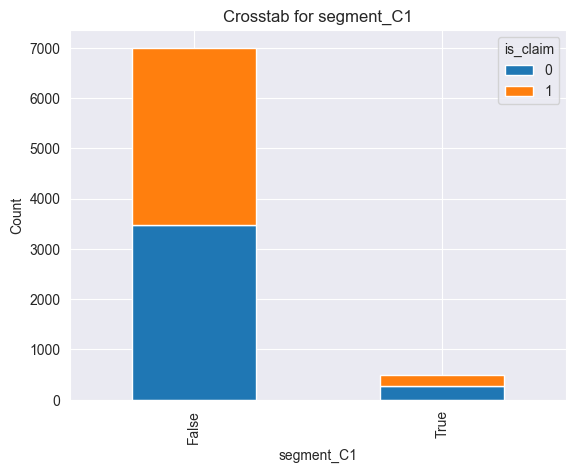

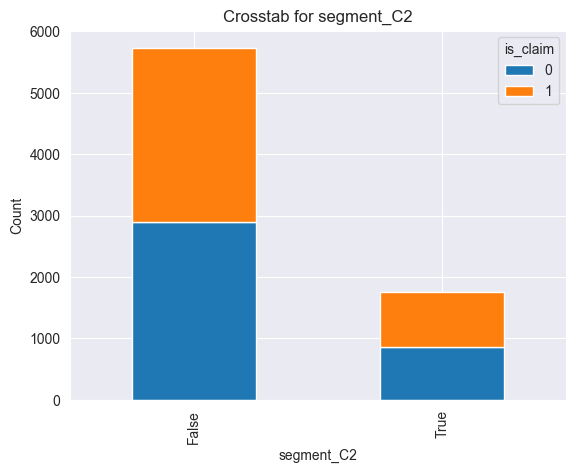

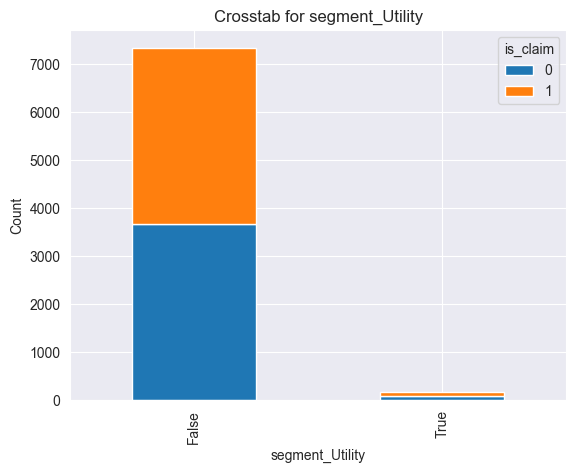

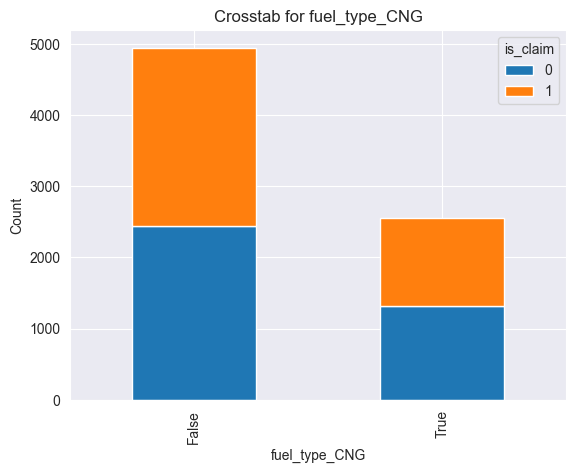

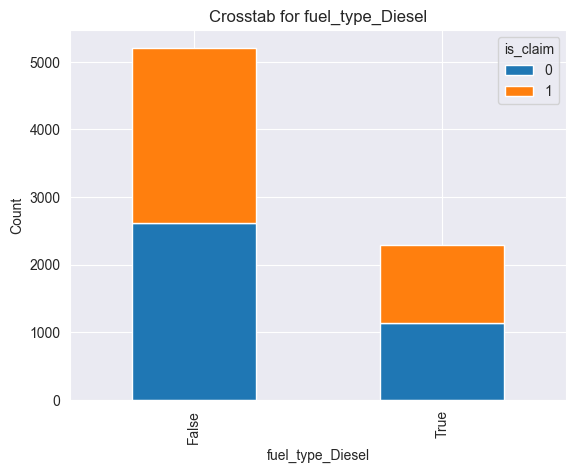

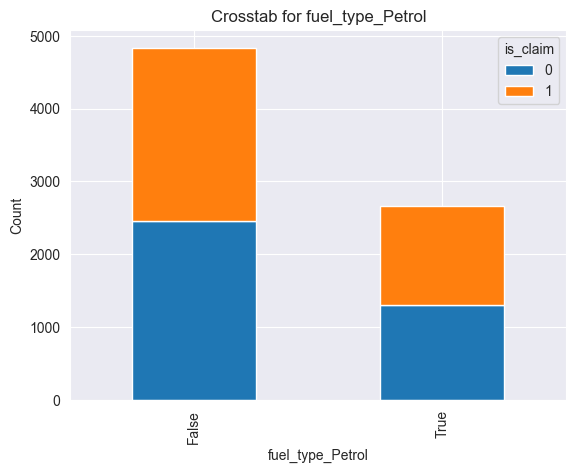

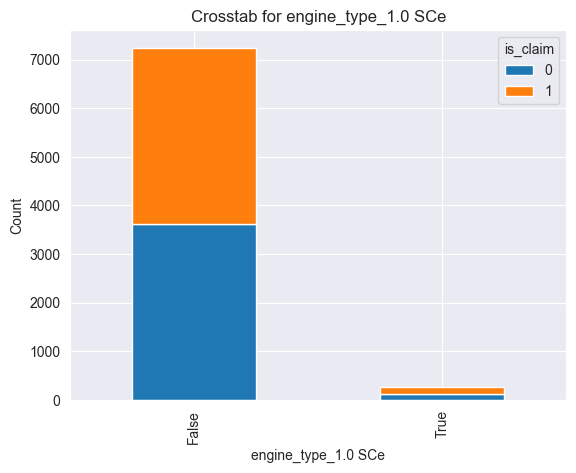

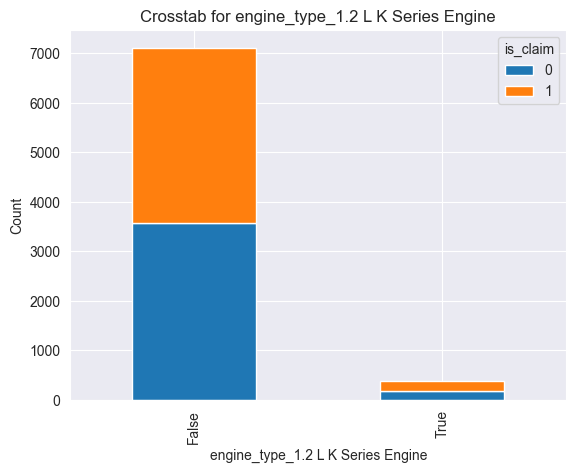

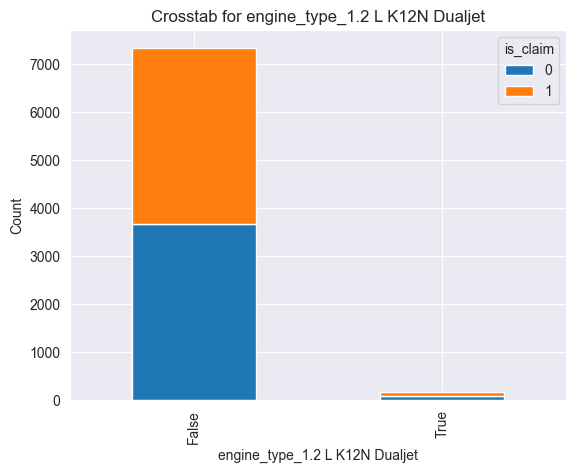

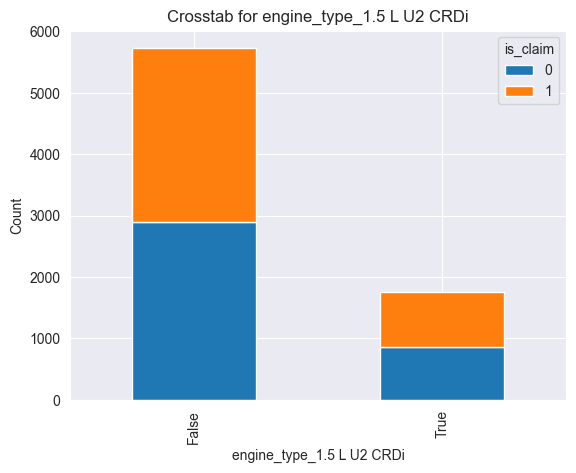

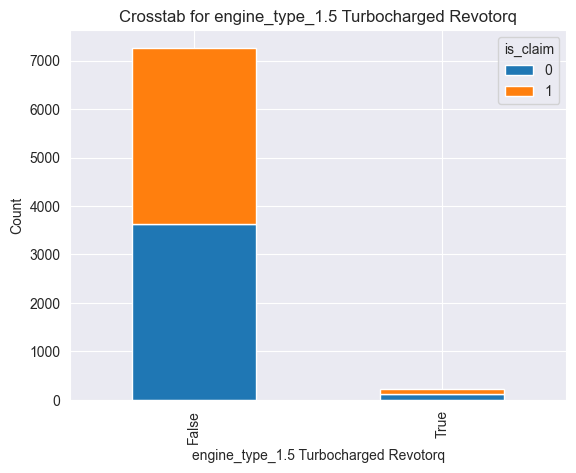

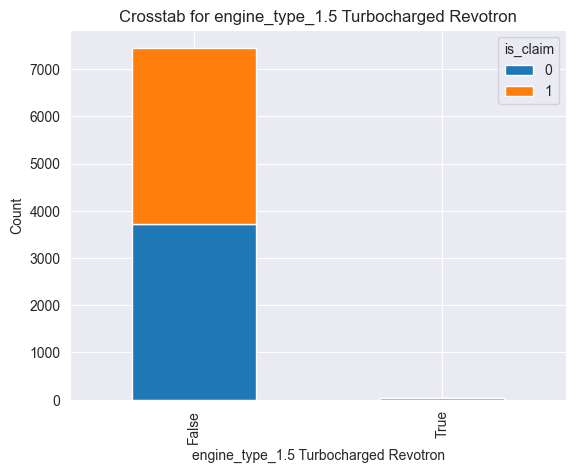

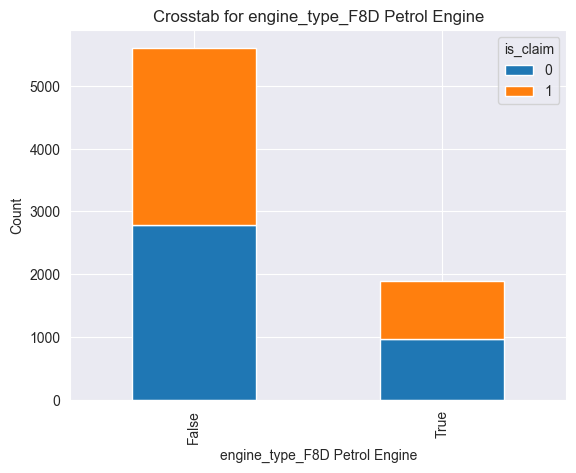

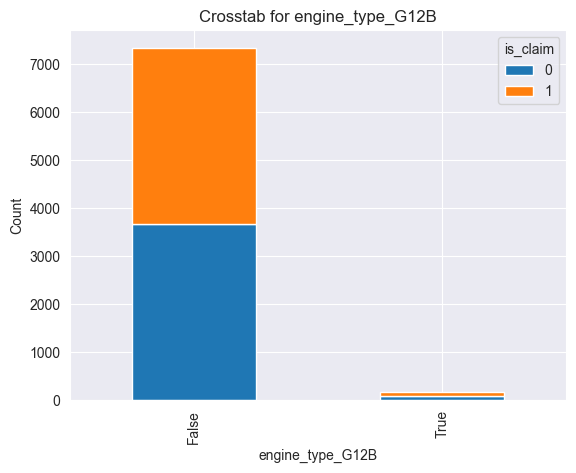

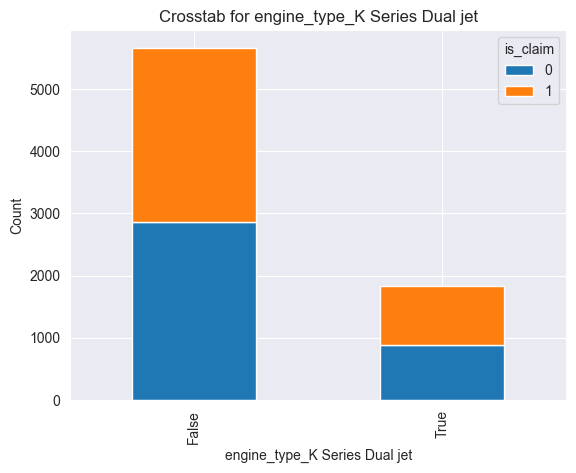

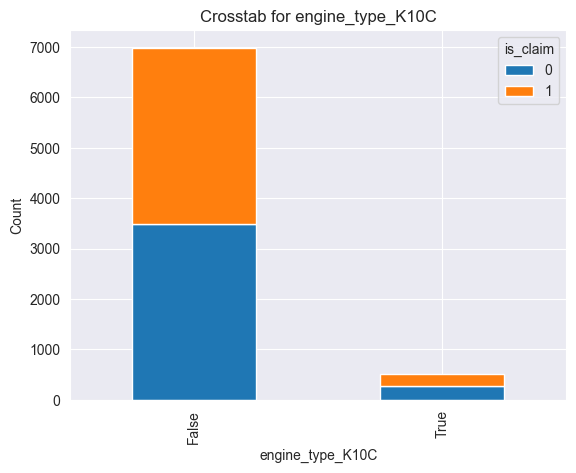

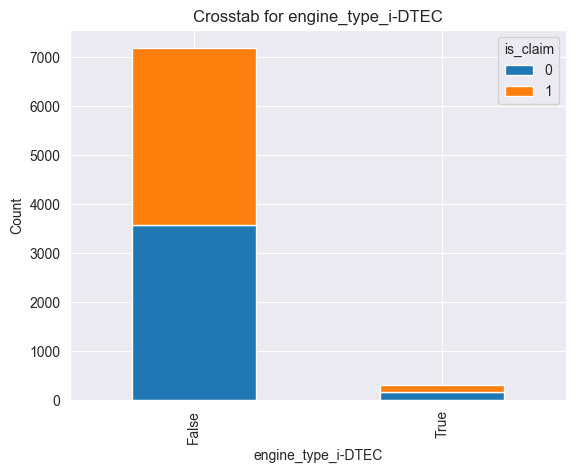

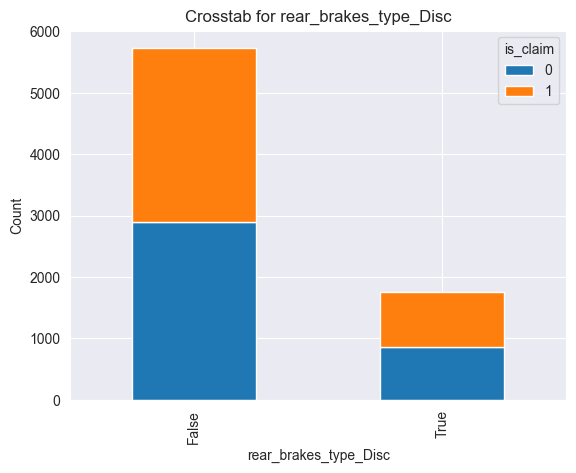

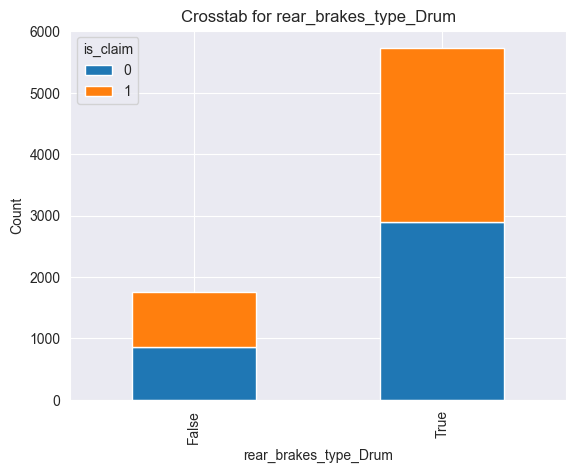

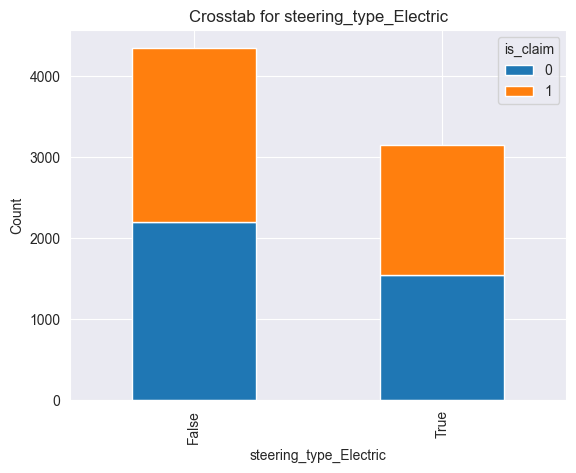

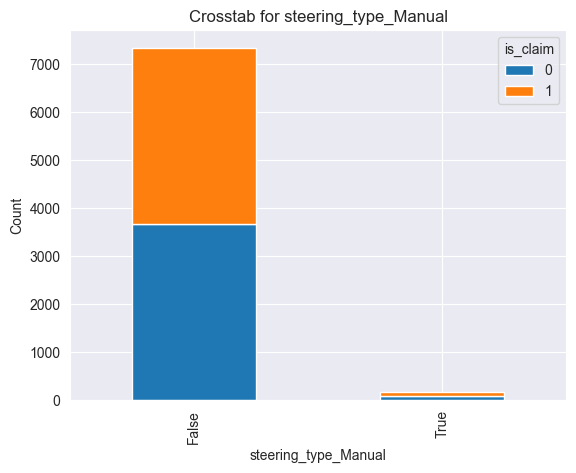

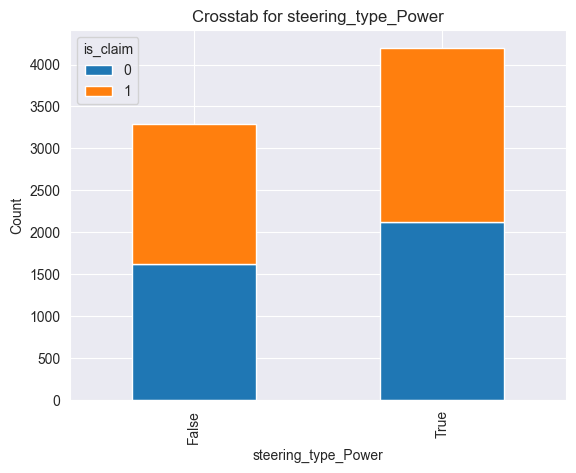

In [181]:
non_numeric_columns = train_data.select_dtypes(exclude='number')

for column in non_numeric_columns:
    if 'id' in column: continue
    crosstab_table = pd.crosstab(train_data[column], train_data['is_claim'])
    crosstab_table.plot(kind='bar', stacked=True)

    plt.title(f'Crosstab for {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

    plt.show()



Numeric features don't correlate with the `is_claim` feature, most probably because it is a binary feature and not a number one.
But there are others features that correlate with each other, which might give more strength to those values, something that we want to avoid.
A good way of avoiding it is to remove the column that correlate too much with another (>= 0.85)

In non-numeric features we didn't get a clear separation but there are some choices that are more favorable. For example in the feature `segment`, people insure more an `A` than a `Utility` value

### Let's now dive into the classifier methods

We have done an initial comparison of all the algorithms

In [13]:
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Neural Network': MLPClassifier(),
    'K-NN': KNeighborsClassifier(),
    'SVM': SVC()
}
target_column = "is_claim"
X = train_data.drop(target_column, axis=1)
y = train_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Numeric features don't correlate with the `is_claim` feature, most probably because it is a binary feature and not a number one.
But there are others features that correlate with each other, which might give more strength to those values, something that we want to avoid.
A good way of avoiding it is to remove the column that correlate too much with another (>= 0.85)

In non-numeric features we didn't get a clear separation but there are some choices that are more favorable. For example in the feature `segment`, people insure more an `A` than a `Utility` value

### Let's now dive into the classifier methods

We have done an initial comparison of all the algorithms

In [11]:
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Neural Network': MLPClassifier(),
    'K-NN': KNeighborsClassifier(),
    'SVM': SVC()
}
target_column = "is_claim"
X = train_data.drop(target_column, axis=1)
y = train_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
        Classifier          Confusion Matrix  Precision    Recall  Accuracy   
0    Decision Tree  [[596, 522], [565, 566]]   0.516805  0.516674  0.516674  \
1    Decision Tree  [[609, 509], [551, 580]]   0.528821  0.528679  0.528679   
2    Decision Tree  [[609, 509], [555, 576]]   0.527058  0.526901  0.526901   
3    Decision Tree  [[601, 517], [562, 569]]   0.520375  0.520231  0.520231   
4    Decision Tree  [[612, 506], [552, 579]]   0.529730  0.529569  0.529569   
5   Neural Network  [[567, 551], [546, 585]]   0.512215  0.512228  0.512228   
6   Neural Network    [[1118, 0], [1131, 0]]   0.750008  0.497110  0.497110   
7   Neural Network  [[27, 1091], [27, 1104]]   0.501489  0.502890  0.502890   
8   Neural Network  [[27, 1091], [24, 1107]]   0.516451  0.504224  0.504224   
9   Neural Network  [[22, 1096], [18, 1113]]   0.526791  0.504669  0.504669   
10            K-NN  [[636, 482], [517, 614]]   0.555937  0.555803  0.555803   
11          

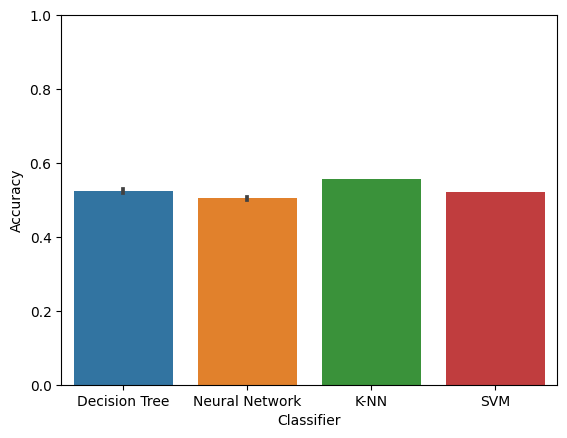

In [12]:
# Train and evaluate the classifiers
results = []

for (name, classifier) in classifiers.items():

    for _ in range(5):
        # Train the model
        start_time = time.time()
        classifier.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Test the model
        start_time = time.time()
        y_pred = classifier.predict(X_test)
        test_time = time.time() - start_time

        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the results
        results.append({
            'Classifier': name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
        })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.ylim(0, 1)
sb.barplot(x='Classifier', y='Accuracy', data=results_df)
plt.show()

### Neural Network

Until now we have only used the default data and model settings.
We are now going to tweak those settings and values to try to get the best results possible.

We tested 5 sets:

- Default Set
- Set without more than 90% correlated information
- Set without more than 80% correlated information
- Set without more than 70% correlated information
- Only data that is correlated to the target feature

With 3 division methods:

- Random division (70/30)
- Random division (80/20)
- Stratified folds (3 folds)

                   Set           Confusion Matrix  Precision    Recall   
0          Default Set     [[5, 1111], [4, 1129]]   0.529592  0.504224  \
1          Default Set     [[0, 1132], [0, 1117]]   0.750011  0.496665   
2          Default Set  [[101, 1028], [94, 1026]]   0.508768  0.501112   
3          Default Set     [[1136, 0], [1113, 0]]   0.750026  0.505113   
4          Default Set     [[0, 1127], [0, 1122]]   0.750001  0.498888   
5   >= 0.9 correlation     [[1134, 0], [1115, 0]]   0.750018  0.504224   
6   >= 0.9 correlation     [[1135, 0], [1114, 0]]   0.750022  0.504669   
7   >= 0.9 correlation     [[1111, 0], [1138, 0]]   0.750036  0.493997   
8   >= 0.9 correlation     [[1096, 0], [1153, 0]]   0.750161  0.487328   
9   >= 0.9 correlation     [[0, 1120], [0, 1129]]   0.750004  0.502001   
10  >= 0.8 correlation     [[1101, 0], [1148, 0]]   0.750109  0.489551   
11  >= 0.8 correlation   [[380, 746], [330, 793]]   0.525254  0.521565   
12  >= 0.8 correlation     [[1125, 6],

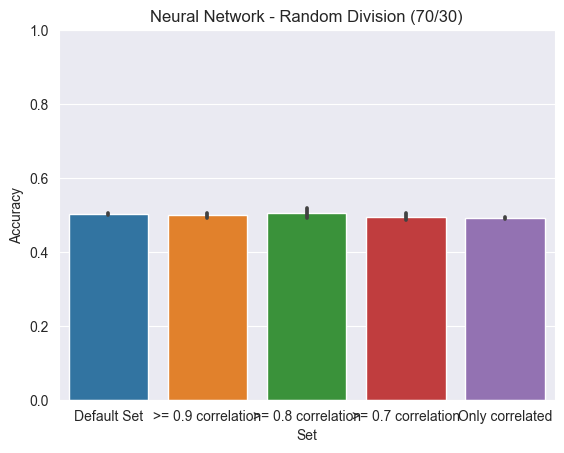

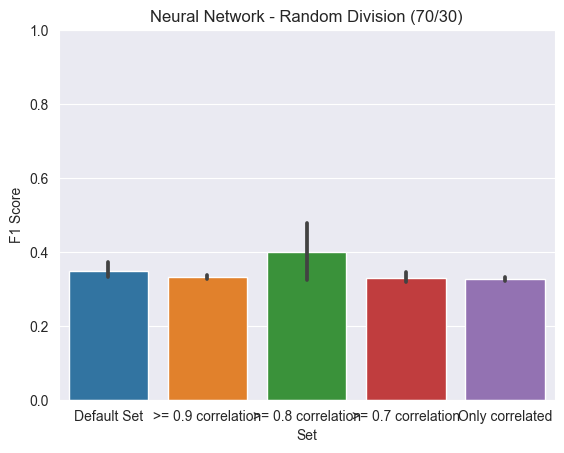

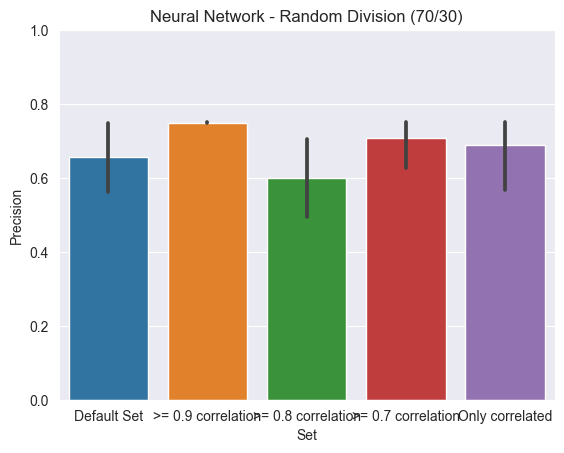

In [194]:
sets = {
    'Default Set': train_data,
    '>= 0.9 correlation': train_data_09,
    '>= 0.8 correlation': train_data_08,
    '>= 0.7 correlation': train_data_07,
    'Only correlated': train_data_nocorr
}


results = []

for (name, data_set) in sets.items():
    # Train the model
    for _ in range(5):  #running 5 times each
        neural_network = MLPClassifier(hidden_layer_sizes=(10, 20, 10), activation='logistic', solver='adam', alpha=0.0001, learning_rate_init=0.002)
        target_column = "is_claim"
        X = data_set.drop(target_column, axis=1)
        y = data_set[target_column]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        start_time = time.time()

        neural_network.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Test the model
        start_time = time.time()
        y_pred = neural_network.predict(X_test)
        test_time = time.time() - start_time

        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the results
        results.append({
            'Set': name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
        })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.ylim(0, 1)
plt.title("Neural Network - Random Division (70/30)")
sb.barplot(x='Set', y='Accuracy', data=results_df)
plt.show()

plt.ylim(0, 1)
plt.title("Neural Network - Random Division (70/30)")
sb.barplot(x='Set', y='F1 Score', data=results_df)
plt.show()

plt.ylim(0, 1)
plt.title("Neural Network - Random Division (70/30)")
sb.barplot(x='Set', y='Precision', data=results_df)
plt.show()

                   Set          Confusion Matrix  Precision    Recall   
0          Default Set  [[565, 192], [541, 202]]   0.511762  0.511333  \
1          Default Set      [[0, 756], [0, 744]]   0.750016  0.496000   
2          Default Set      [[0, 781], [0, 719]]   0.750427  0.479333   
3          Default Set      [[0, 732], [0, 768]]   0.750144  0.512000   
4          Default Set      [[764, 0], [736, 0]]   0.750087  0.509333   
5   >= 0.9 correlation  [[146, 607], [121, 626]]   0.527339  0.514667   
6   >= 0.9 correlation    [[48, 701], [33, 718]]   0.549234  0.510667   
7   >= 0.9 correlation      [[0, 748], [0, 752]]   0.750002  0.501333   
8   >= 0.9 correlation      [[0, 728], [0, 772]]   0.750215  0.514667   
9   >= 0.9 correlation      [[0, 756], [0, 744]]   0.750016  0.496000   
10  >= 0.8 correlation      [[766, 0], [734, 0]]   0.750114  0.510667   
11  >= 0.8 correlation    [[12, 745], [10, 733]]   0.520929  0.496667   
12  >= 0.8 correlation      [[0, 764], [0, 736]]   

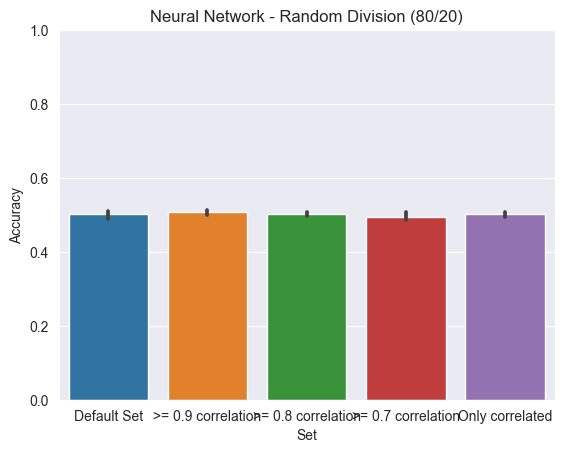

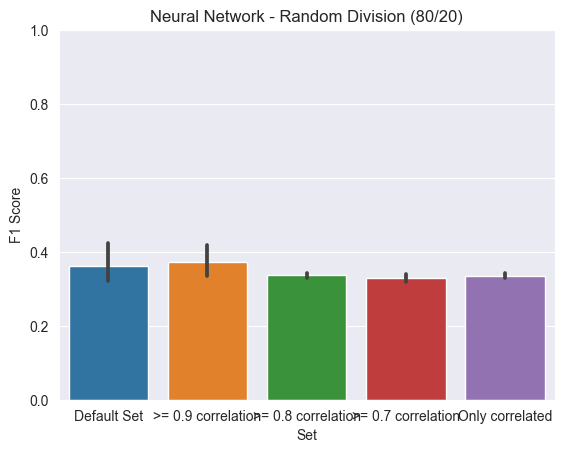

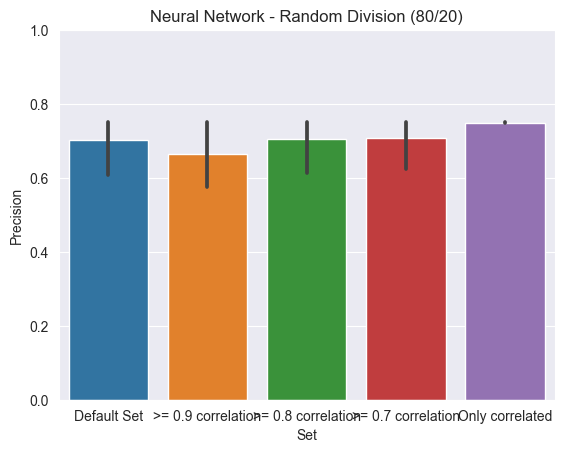

In [195]:
sets = {
    'Default Set': train_data,
    '>= 0.9 correlation': train_data_09,
    '>= 0.8 correlation': train_data_08,
    '>= 0.7 correlation': train_data_07,
    'Only correlated': train_data_nocorr
}

results = []

for (name, data_set) in sets.items():
    # Train the model
    for _ in range(5):  #running 5 times each
        neural_network = MLPClassifier(hidden_layer_sizes=(10, 20, 10), activation='logistic', solver='adam', alpha=0.0001, learning_rate_init=0.002)
        target_column = "is_claim"
        X = data_set.drop(target_column, axis=1)
        y = data_set[target_column]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        start_time = time.time()

        neural_network.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Test the model
        start_time = time.time()
        y_pred = neural_network.predict(X_test)
        test_time = time.time() - start_time

        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the results
        results.append({
            'Set': name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
        })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.ylim(0, 1)
plt.title("Neural Network - Random Division (80/20)")
sb.barplot(x='Set', y='Accuracy', data=results_df)
plt.show()

plt.ylim(0, 1)
plt.title("Neural Network - Random Division (80/20)")
sb.barplot(x='Set', y='F1 Score', data=results_df)
plt.show()

plt.ylim(0, 1)
plt.title("Neural Network - Random Division (80/20)")
sb.barplot(x='Set', y='Precision', data=results_df)
plt.show()

                   Set          Confusion Matrix  Precision    Recall   
0          Default Set  [[316, 933], [353, 897]]   0.481259  0.485394  \
1          Default Set    [[1250, 0], [1249, 0]]   0.750000  0.500200   
2          Default Set    [[1249, 0], [1249, 0]]   0.750000  0.500000   
3   >= 0.9 correlation    [[1249, 0], [1250, 0]]   0.750000  0.499800   
4   >= 0.9 correlation    [[0, 1250], [0, 1249]]   0.750000  0.499800   
5   >= 0.9 correlation    [[1249, 0], [1249, 0]]   0.750000  0.500000   
6   >= 0.8 correlation  [[355, 894], [337, 913]]   0.509130  0.507403   
7   >= 0.8 correlation  [[308, 942], [292, 957]]   0.508643  0.506202   
8   >= 0.8 correlation  [[15, 1234], [13, 1236]]   0.518060  0.500801   
9   >= 0.7 correlation   [[19, 1230], [8, 1242]]   0.603025  0.504602   
10  >= 0.7 correlation    [[1250, 0], [1249, 0]]   0.750000  0.500200   
11  >= 0.7 correlation  [[559, 690], [521, 728]]   0.515496  0.515212   
12     Only correlated    [[1249, 0], [1250, 0]]   

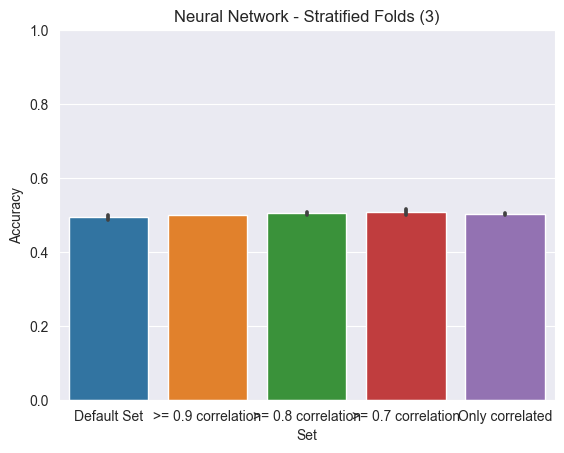

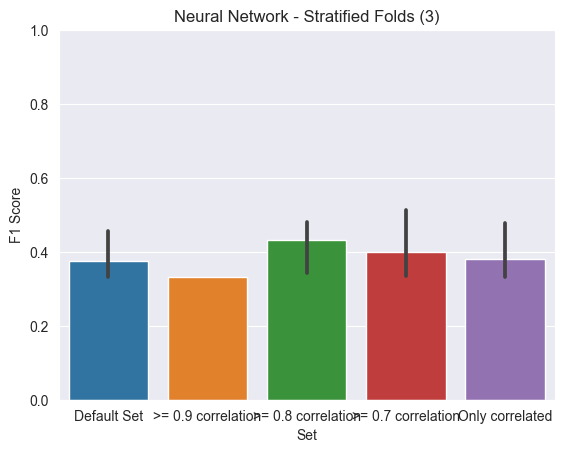

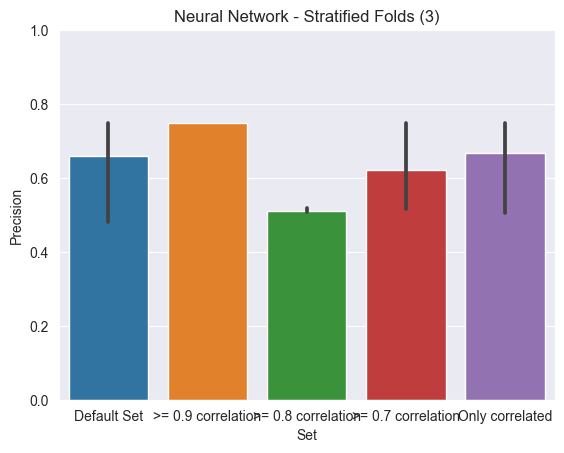

In [197]:
sets = {
    'Default Set': train_data,
    '>= 0.9 correlation': train_data_09,
    '>= 0.8 correlation': train_data_08,
    '>= 0.7 correlation': train_data_07,
    'Only correlated': train_data_nocorr
}


results = []
skf = StratifiedKFold(n_splits=3)

for (name, data_set) in sets.items():
    neural_network = MLPClassifier(hidden_layer_sizes=(10, 20, 10), activation='logistic', solver='adam', alpha=0.0001, learning_rate_init=0.002)
    target_column = "is_claim"
    X = data_set.drop(target_column, axis=1)
    y = data_set[target_column]
    for train_index, test_index in skf.split(X, y):
        # Train the model
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        start_time = time.time()

        neural_network.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Test the model
        start_time = time.time()
        y_pred = neural_network.predict(X_test)
        test_time = time.time() - start_time

        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the results
        results.append({
            'Set': name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
        })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.ylim(0, 1)
plt.title("Neural Network - Stratified Folds (3)")
sb.barplot(x='Set', y='Accuracy', data=results_df)
plt.show()

plt.ylim(0, 1)
plt.title("Neural Network - Stratified Folds (3)")
sb.barplot(x='Set', y='F1 Score', data=results_df)
plt.show()

plt.ylim(0, 1)
plt.title("Neural Network - Stratified Folds (3)")
sb.barplot(x='Set', y='Precision', data=results_df)
plt.show()

We can conclude that the results didn't change much with the different sets and tweaks made in the neural network. Still, the `Only correlated` set performs well in the 80/20 random division (highest precision).

There is still some possible work in the data to improve the overall results.

### Decision Tree

Regarding the Decision Tree model, we used the GridSearchCV component of the sklearn package in order to find out the parameters combination that produces the best outcome, for each dataset. Furthermore, we also use some plots to make the comparison easier and more intuitive.

In [16]:
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [1, 2, 5, 10, 20, 40, 80, 160, 320, 640, None],
    'min_samples_split': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'max_features': [None] + [x for x in range(1, len(train_data.columns))]
}
names = ['Train Data', 'Train Data 07', 'Train Data 08', 'Train Data 09']
datasets = [train_data, train_data_07, train_data_08, train_data_09]
target_column = "is_claim"
results = []

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 43, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'splitter': 'best'}
{'criterion': 'entropy', 'max_depth': 80, 'max_features': 4, 'min_samples_leaf': 0.1, 'min_samples_split': 0.3, 'splitter': 'best'}
{'criterion': 'entropy', 'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.4, 'splitter': 'best'}
{'criterion': 'gini', 'max_depth': 320, 'max_features': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2, 'splitter': 'best'}


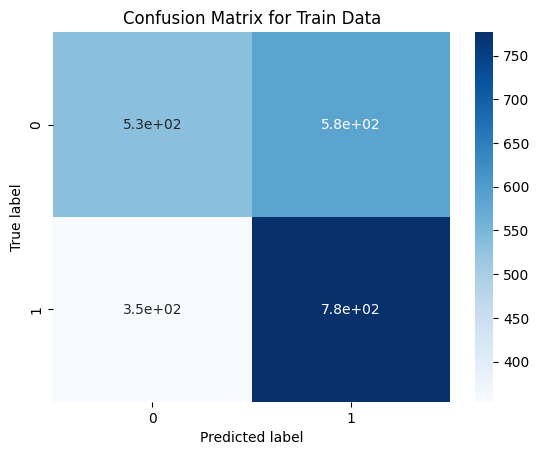

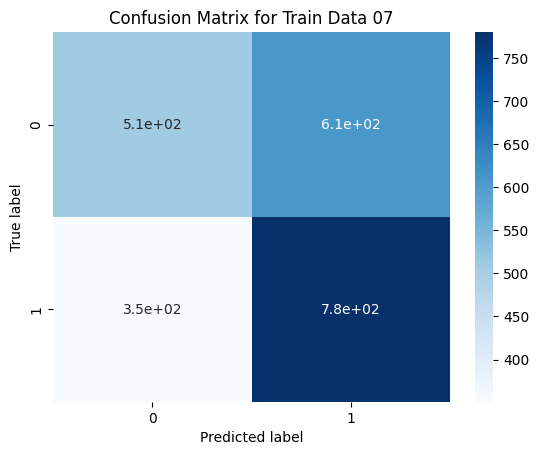

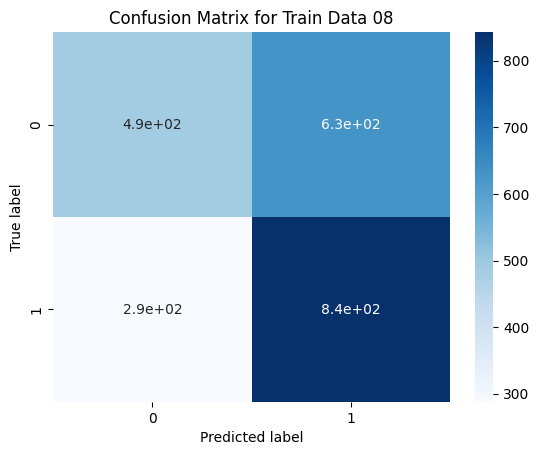

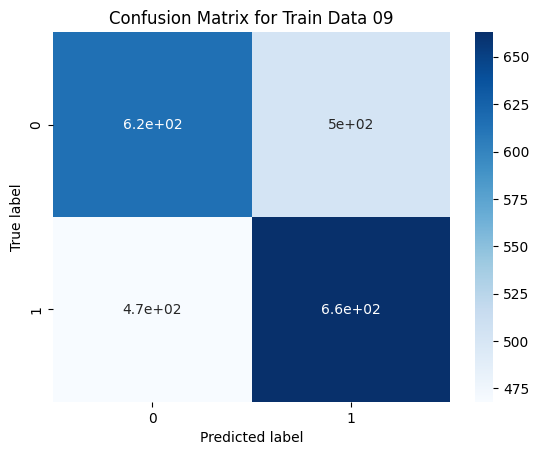

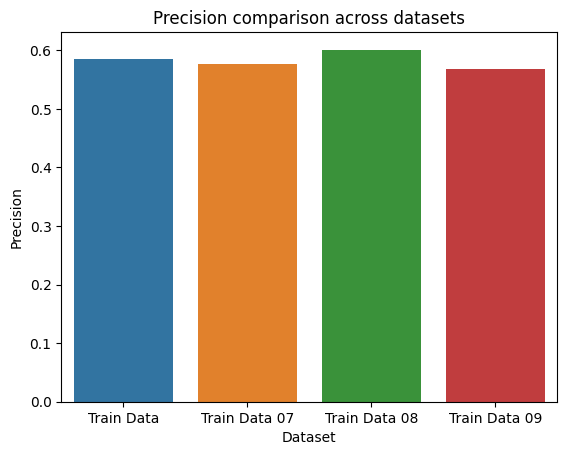

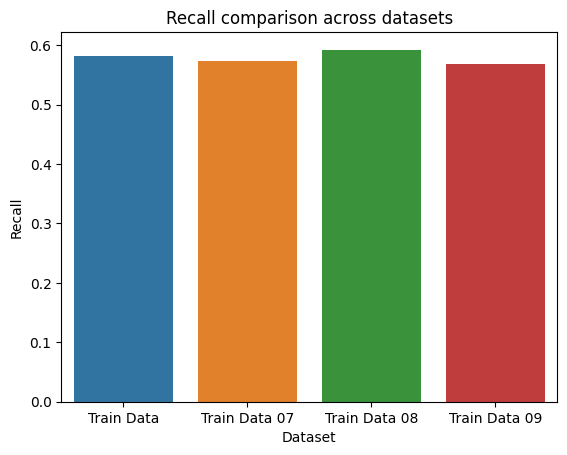

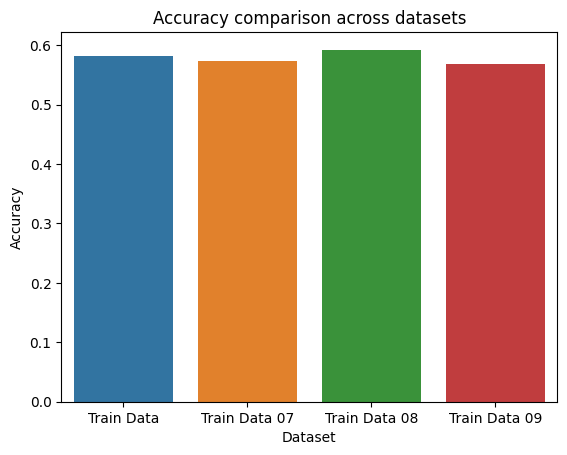

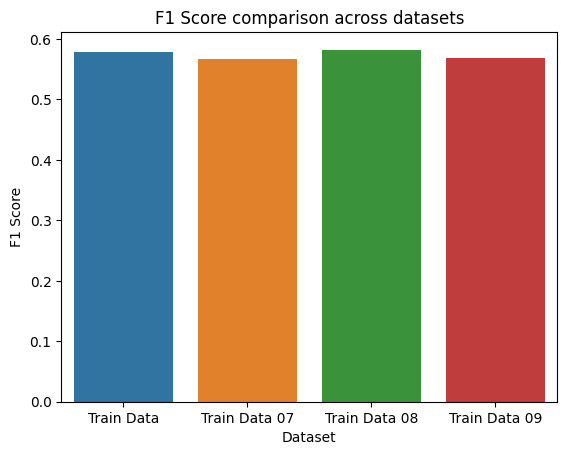

In [17]:

from sklearn.model_selection import GridSearchCV

for dataset in datasets:
    X = dataset.drop(target_column, axis=1)
    y = dataset[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid=params, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    y_pred = grid_search.predict(X_test)
    print(best_params)
    # Best params results:
    # {'criterion': 'entropy', 'max_depth': 20, 'max_features': 32, 'min_samples_leaf': 0.1, 'min_samples_split': 0.5, 'splitter': 'best'}
    # {'criterion': 'entropy', 'max_depth': 20, 'max_features': 3, 'min_samples_leaf': 0.1, 'min_samples_split': 0.6, 'splitter': 'best'}
    # {'criterion': 'entropy', 'max_depth': 640, 'max_features': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.6, 'splitter': 'best'}
    # {'criterion': 'gini', 'max_depth': 10, 'max_features': 6, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2, 'splitter': 'best'}

    conf_matrix = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store the results
    results.append({
        'Confusion Matrix': conf_matrix,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'F1 Score': f1,
    })
for i, result in enumerate(results):
    # Create a heatmap of the confusion matrix
    sb.heatmap(result['Confusion Matrix'], annot=True, cmap='Blues')

    # Add labels and title to the plot
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix for ' + names[i])

    # Show the plot
    plt.show()
metrics = ['Precision', 'Recall', 'Accuracy', 'F1 Score']
for metric in metrics:
    # Extract the metric values for each dataset
    values = [result[metric] for result in results]

    # Create a bar plot to compare the metric values
    sb.barplot(x=names, y=values)

    # Add labels and title to the plot
    plt.xlabel('Dataset')
    plt.ylabel(metric)
    plt.title(f'{metric} comparison across datasets')

    # Show the plot
    plt.show()